In [1]:
import openchord as ocd
import pandas as pd
import networkx as nx
import os
import matplotlib.pyplot as plt
# go one up
os.chdir("..")

In [2]:
vos_links = pd.read_csv(f'data{os.sep}prepared{os.sep}vos_links.csv')
vos_links.head()

,VOS_Source_ID,VOS_Target_ID,Strength
0,2,3,2.4269
1,2,4,0.0215
2,2,7,0.0081
3,2,8,0.3474
4,2,10,0.1061


In [3]:
vos_links.max()

VOS_Source_ID    3453.0000
VOS_Target_ID    3454.0000
Strength           74.7694
dtype: float64

In [4]:
vos_meta = pd.read_csv(f'data{os.sep}prepared{os.sep}vos_meta.csv')
# Remove the duplicates with the same Title
vos_meta = vos_meta.drop_duplicates(subset='Title')
vos_meta.head()

,VOS_ID,Authors,Title,Year,Citations,Source,Cluster,Links,Total link strength,Norm. citations
0,2,['Nick Bostrom'],Existential Risk Prevention As Global Priority,2013,387.0,Global policy,3,303.0,33.0,11.8575
1,3,['Nick Bostrom'],Existential Risks: Analyzing Human Extinction ...,2002,176.0,[no source],3,61.0,24.0,3.7625
2,4,"['Shahar Avin', ' Bonnie C. Wintle', ' Julius ...",Classifying Global Catastrophic Risks,2018,68.0,Futures,3,226.0,13.0,4.6723
3,7,"['Simon Beard', ' Lauren Holt', ' Asaf Tzachor...",Assessing Climate Change’S Contribution To Glo...,2021,41.0,Futures,3,287.0,56.0,5.3588
4,8,"['Alexey Turchin', ' David Denkenberger']",Classification Of Global Catastrophic Risks Co...,2018,53.0,Ai & society,1,208.0,22.0,3.6416


In [5]:
# Remove the discarded clusters
other_topic_clusters = [6, 7, 8, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23]
vos_meta = vos_meta[~vos_meta['Cluster'].isin(other_topic_clusters)]

In [6]:
# Merge via the 'VOS_ID' column
vos_source = pd.merge(vos_links, vos_meta, right_on='VOS_ID', left_on='VOS_Source_ID', how="right")
vos_source = vos_source[['VOS_Source_ID', 'VOS_Target_ID', "Strength", "Cluster"]]
vos_source.columns = ['Source', 'Target', 'Strength', 'Source Cluster']
vos_source.head()

,Source,Target,Strength,Source Cluster
0,2.0,3.0,2.4269,3
1,2.0,4.0,0.0215,3
2,2.0,7.0,0.0081,3
3,2.0,8.0,0.3474,3
4,2.0,10.0,0.1061,3


In [7]:
# Merge again to get the target cluster
vos_target = pd.merge(vos_links, vos_meta, right_on='VOS_ID', left_on='VOS_Target_ID', how="right")
vos_target = vos_target[['VOS_Source_ID', 'VOS_Target_ID', "Strength", "Cluster"]]
vos_target.columns = ['Source', 'Target', 'Strength', 'Target Cluster']
vos_target.head()


,Source,Target,Strength,Target Cluster
0,NaN,NaN,NaN,3
1,2.0,3.0,2.4269,3
2,2.0,4.0,0.0215,3
3,2.0,7.0,0.0081,3
4,4.0,7.0,0.0906,3


In [8]:
#assert vos_target.shape[0] == vos_source.shape[0]
# Merge the two dataframes
vos = pd.merge(vos_source, vos_target, on=['Source', 'Target', 'Strength'])
vos.head()

,Source,Target,Strength,Source Cluster,Target Cluster
0,2.0,3.0,2.4269,3,3
1,2.0,4.0,0.0215,3,3
2,2.0,7.0,0.0081,3,3
3,2.0,8.0,0.3474,3,1
4,2.0,10.0,0.1061,3,3


In [9]:
# Analyse how much strength is from one cluster to another
cluster_strength = vos[["Strength", "Source Cluster", "Target Cluster"]].groupby(['Source Cluster', 'Target Cluster']).sum()
cluster_strength

Strength
Source Cluster Target Cluster           
1              1               1257.0586
               2                 57.0849
               3                131.4128
               4                 44.7639
               5                 27.2638
...                                  ...
17             5                  2.7500
               9                  1.3155
               10                 0.5000
               12                 1.3657
               17               128.0154

[99 rows x 1 columns]

In [10]:
# Create a graph from the cluster strength
G = nx.Graph()
for index, row in cluster_strength.iterrows():
    # Skip self loops
    if index[0] == index[1]:
        continue
    G.add_edge(index[0], index[1], weight=row['Strength'])

In [11]:
adjacency_matrix = nx.to_pandas_adjacency(G)
adjacency_matrix

,1,2,3,4,5,9,10,11,12,17
1,0.0000,47.3250,220.1671,53.8133,20.3532,39.0003,20.6449,33.6338,7.0691,16.7645
2,47.3250,0.0000,203.4086,55.2769,30.4639,4.6886,8.6565,44.5001,16.7954,6.3832
3,220.1671,203.4086,0.0000,32.4322,16.7527,22.7222,11.2116,68.3828,6.5482,1.7353
4,53.8133,55.2769,32.4322,0.0000,28.2812,4.1536,2.5077,22.4657,7.6193,2.7500
5,20.3532,30.4639,16.7527,28.2812,0.0000,3.8779,8.5679,11.9981,3.9411,2.7500
9,39.0003,4.6886,22.7222,4.1536,3.8779,0.0000,1.9055,2.6328,0.9040,1.3155
10,20.6449,8.6565,11.2116,2.5077,8.5679,1.9055,0.0000,2.2496,0.1022,0.5000
11,33.6338,44.5001,68.3828,22.4657,11.9981,2.6328,2.2496,0.0000,1.7772,0.0873
12,7.0691,16.7954,6.5482,7.6193,3.9411,0.9040,0.1022,1.7772,0.0000,1.3657
17,16.7645,6.3832,1.7353,2.7500,2.7500,1.3155,0.5000,0.0873,1.3657,0.0000


In [12]:
# Get an adjacency matrix
adjacency_matrix.columns = ["Artificial\nIntelligence", "Climate Change", "Foundations", "Governance", "Pandemics", "Transhumanism", "Reasoning\nand Risk", "Global Resilience\nand Food Security", "Risk Management\nand Mitigation", "Emerging Biotechnologies,\nEmerging Futures"]
adjacency_matrix.index = ["Artificial\nIntelligence", "Climate Change", "Foundations", "Governance", "Pandemics", "Transhumanism", "Reasoning\nand Risk", "Global Resilience\nand Food Security", "Risk Management\nand Mitigation", "Emerging Biotechnologies,\nEmerging Futures"]
adjacency_matrix

,Artificial\nIntelligence,Climate Change,Foundations,Governance,Pandemics,Transhumanism,Reasoning\nand Risk,Global Resilience\nand Food Security,Risk Management\nand Mitigation,"Emerging Biotechnologies,\nEmerging Futures"
Artificial\nIntelligence,0.0000,47.3250,220.1671,53.8133,20.3532,39.0003,20.6449,33.6338,7.0691,16.7645
Climate Change,47.3250,0.0000,203.4086,55.2769,30.4639,4.6886,8.6565,44.5001,16.7954,6.3832
Foundations,220.1671,203.4086,0.0000,32.4322,16.7527,22.7222,11.2116,68.3828,6.5482,1.7353
Governance,53.8133,55.2769,32.4322,0.0000,28.2812,4.1536,2.5077,22.4657,7.6193,2.7500
Pandemics,20.3532,30.4639,16.7527,28.2812,0.0000,3.8779,8.5679,11.9981,3.9411,2.7500
Transhumanism,39.0003,4.6886,22.7222,4.1536,3.8779,0.0000,1.9055,2.6328,0.9040,1.3155
Reasoning\nand Risk,20.6449,8.6565,11.2116,2.5077,8.5679,1.9055,0.0000,2.2496,0.1022,0.5000
Global Resilience\nand Food Security,33.6338,44.5001,68.3828,22.4657,11.9981,2.6328,2.2496,0.0000,1.7772,0.0873
Risk Management\nand Mitigation,7.0691,16.7954,6.5482,7.6193,3.9411,0.9040,0.1022,1.7772,0.0000,1.3657
"Emerging Biotechnologies,\nEmerging Futures",16.7645,6.3832,1.7353,2.7500,2.7500,1.3155,0.5000,0.0873,1.3657,0.0000


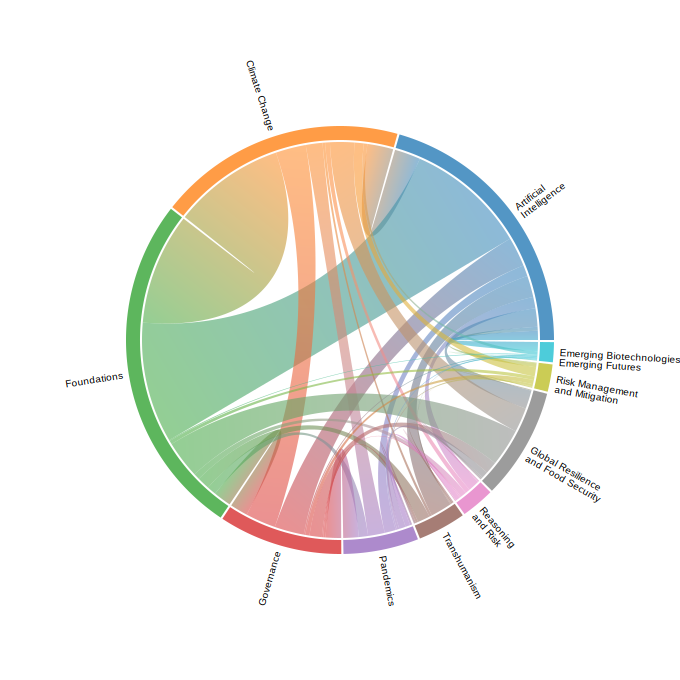

In [13]:
chord = ocd.Chord(adjacency_matrix, [str(i) for i in adjacency_matrix.columns])
# Get the colors from tab10
chord.colormap = ["#418bbf", "#ff9232", "#4cae4c", "#dc4748", "#a47ec7", "#9d6f66", "#e78bcb", "#929292", "#c6c743", "#3ac7d6"]
chord.padding = 140
chord.show()

In [14]:
# Save the chord diagram
chord.save_svg(f"results{os.sep}figure_2.svg")